---

<div style="text-align: center; font-family: Arial, sans-serif; margin-top: 50px;">
    <h1 style="font-size: 36px; font-weight: bold;"><b>Prácticas de NLP - Sesión 3</b></h1>
    <h2 style="font-size: 28px; color: #2E86C1;"><b>Mini-Proyecto de clasificación de texto con Transformers</b></h2>
    <p style="font-size: 20px; margin-top: 30px;">
        <b>Materia:</b> Procesamiento de Lenguaje Natural<br>
        <b>Estudiantes:</b> Albin Rivera y Yesid Castelblanco<br>
        <b>Fecha:</b> 30 de Agosto de 2025
    </p>
</div>

---

# **1. Configuración Inicial**
---

<p style="font-size: 16px;">
    En esta sección se definen los parámetros base y las configuraciones generales del proyecto.<br>
    Aquí normalmente se incluyen variables globales, rutas de acceso a datos, definiciones de constantes y parámetros que van a ser utilizados en las siguientes fases del pipeline de NLP.

In [ ]:
import subprocess
import sys
import os
import logging
import warnings
import pkg_resources
from collections import Counter
import torch
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, logging as hf_logging
from torch.optim import AdamW
from transformers import get_cosine_schedule_with_warmup
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from tqdm.auto import tqdm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, AUROC, CalibrationError, ConfusionMatrix
from peft import LoraConfig, get_peft_model

# **2. Configuración entorno de trabajo e instalación de dependencias**
---

<p style="font-size: 16px;">
    Se instalan y cargan las librerías necesarias para el proyecto, como transformers, torch, pytorch_lightning, datasets, entre otras.<br>
    También se pueden incluir comandos de instalación con pip o configuraciones de compatibilidad entre versiones.

In [5]:
# Configuración de logging
logging.basicConfig(
    filename='training.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)
logging.getLogger("xla").setLevel(logging.CRITICAL)
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger().setLevel(logging.CRITICAL)
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    sys.stderr = open('/dev/null', 'w')

# Detectar entorno (Kaggle, Colab o local)
IN_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ
IN_COLAB = False
if not IN_KAGGLE:
    try:
        import google.colab
        IN_COLAB = True
        print("Ejecutando en Google Colab...")
        logger.info("Ejecutando en Google Colab")
    except ImportError:
        print("Ejecutando localmente...")
        logger.info("Ejecutando localmente")
else:
    print("Ejecutando en Kaggle...")
    logger.info("Ejecutando en Kaggle")

# Instalar dependencias con salida suprimida
def install_package(package, extra_index_url=None):
    cmd = [sys.executable, "-m", "pip", "install", package, "--quiet", "--no-warn-conflicts"]
    if extra_index_url:
        cmd.extend(["--index-url", extra_index_url])
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

def check_package(package_name, required_version):
    try:
        installed_version = pkg_resources.get_distribution(package_name).version
        return installed_version == required_version
    except pkg_resources.DistributionNotFound:
        return False

if IN_COLAB or IN_KAGGLE:
    if not check_package("torch", "2.7.1"):
        install_package("torch==2.7.1 torchvision==0.22.1 torchaudio==2.7.1", "https://download.pytorch.org/whl/cu118")
    if not check_package("numpy", "1.26.4"):
        install_package("numpy==1.26.4 pandas==2.2.2 pyarrow==15.0.2")
    if not check_package("lightning", "2.4.0"):
        install_package("lightning==2.4.0 datasets==3.0.1 transformers==4.45.2 sentence-transformers==3.2.1 peft==0.13.2 nltk==3.9.1")
    if not check_package("nlpaug", "1.1.11"):
        install_package("nlpaug==1.1.11")

import nlpaug.augmenter.word as naw

# Configurar caché persistente en Kaggle
if IN_KAGGLE:
    cache_dir = "/kaggle/working/hf_cache"
    os.makedirs(cache_dir, exist_ok=True)
    os.environ["HF_HOME"] = cache_dir

# Verificar instalación de paquetes clave
try:
    import numpy
    import transformers
    import nlpaug
    import torch
    import datasets
except ImportError as e:
    logger.error(f"Error al importar un paquete clave: {e}")
    print(f"Error al importar un paquete clave: {e}")
    raise

# Configuraciones para compatibilidad
num_workers = 0 if IN_COLAB or IN_KAGGLE else 8
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
stop_words = set(stopwords.words('spanish'))

# Suprimir advertencias y configurar entorno
warnings.filterwarnings('ignore')
os.environ["TOKENIZERS_PARALLELISM"] = "false"
hf_logging.set_verbosity_error()
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/lib/cuda"
torch.set_float32_matmul_precision('medium')

Ejecutando en Kaggle...


# **3. Funciones de Preprocesamiento de textos,carga de dataset, pretokenización, y división del dataset**
---

<p style="font-size: 16px;">
    En esta parte se define el flujo para preparar los datos antes de entrenar el modelo:<br>
    <p style="font-size: 16px;">
        * Carga del dataset: Importar datos desde archivos locales o repositorios externos.<br>
    </p>
    <p style="font-size: 16px;">
        * Limpieza y normalización: Conversión a minúsculas, eliminación de caracteres especiales, etc.<br>
    </p>
    <p style="font-size: 16px;">
        * Tokenización: Conversión de texto a secuencias de tokens utilizando un modelo base (por ejemplo, BERT tokenizer).<br>
    </p>
    <p style="font-size: 16px;">
        * División: Separación en subconjuntos de entrenamiento, validación y prueba.
    </p>

In [7]:
# Preprocesamiento de Textos
def preprocess_text(text):
    if not isinstance(text, str) or not text.strip():
        return "texto_vacío"
    return text.lower().strip()

# Cargar y Explorar Dataset
def load_and_explore_dataset():
    dataset = load_dataset("mariagrandury/fake_news_corpus_spanish", split="test")
    df = dataset.to_pandas()
    df['CATEGORY'] = df['CATEGORY'].astype(int)
    df['TEXT'] = df['TEXT'].apply(preprocess_text)
    class_counts = Counter(df['CATEGORY'])
    total = sum(class_counts.values())
    class_weights = {k: total / (len(class_counts) * v) for k, v in class_counts.items()}
    print(f"Total de Textos: {len(df)}, Clases: {class_counts}")
    logger.info(f"Dataset cargado con {len(df)} ejemplos, Clases: {class_counts}")
    return dataset, torch.tensor([class_weights[i] for i in range(len(class_weights))])

# Pre-tokenización
def preprocess_dataset(dataset, tokenizer, seq_length=256):
    def tokenize_function(examples):
        tokenized = tokenizer(
            [preprocess_text(text) for text in examples['TEXT']],
            max_length=seq_length,
            padding='max_length',
            truncation=True
        )
        tokenized['labels'] = [1 if cat == 1 else 0 for cat in examples['CATEGORY']]
        return tokenized
    return dataset.map(
        tokenize_function,
        batched=True,
        batch_size=500,  # Controlar tamaño de lote para evitar desajustes
        num_proc=4 if not (IN_COLAB or IN_KAGGLE) else 1,
        remove_columns=dataset.column_names  # Eliminar todas las columnas originales
    )

# Dividir Dataset
def split_dataset(dataset):
    dataset_size = len(dataset)
    train_size = int(0.8 * dataset_size)
    val_size = int(0.1 * dataset_size)
    test_size = dataset_size - train_size - val_size
    train_subset, val_subset, test_subset = random_split(
        dataset, lengths=[train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
    )
    return train_subset, val_subset, test_subset

# **4. Ajuste del dataset personalizado**
---

<p style="font-size: 16px;">
    Aquí se adaptan los datos procesados a una estructura compatible con PyTorch o PyTorch Lightning.<br>
    Se pueden definir clases personalizadas (Dataset) para manejar la carga de datos en lotes (batching), shuffling y optimización en GPU.

In [8]:
# Clase de Dataset Personalizado
class FakeNewsCorpusSpanishDataset(Dataset):
    def __init__(self, tokenized_dataset, augment=False, model_name="dccuchile/bert-base-spanish-wwm-cased"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenized_dataset = tokenized_dataset
        self.augment = augment
        self.aug_context = None if not augment else naw.ContextualWordEmbsAug(
            model_path=model_name, aug_p=0.15, action="substitute", device='cuda' if torch.cuda.is_available() else 'cpu'
        )
        self.aug_synonym = None if not augment else naw.SynonymAug(aug_p=0.3, aug_max=4)
        self.id_2_class_map = {0: 'False', 1: 'True'}
        self.class_2_id_map = {'False': 0, 'True': 1}
        self.num_classes = len(self.id_2_class_map)

    def __getitem__(self, index):
        item = self.tokenized_dataset[index]
        text = self.tokenizer.decode(item['input_ids'], skip_special_tokens=True)
        if self.augment and self.aug_context:
            if np.random.rand() < 0.6:
                try:
                    text = self.aug_context.augment(text)[0]
                    text = self.aug_synonym.augment(text)[0]
                    tokenized = self.tokenizer(
                        text, max_length=256, padding='max_length', truncation=True, return_tensors='pt'
                    )
                    input_ids = tokenized['input_ids'].squeeze(0)
                    attention_mask = tokenized['attention_mask'].squeeze(0)
                except (ValueError, IndexError) as e:
                    logger.warning(f"Error en aumentación: {e}")
                    input_ids = torch.tensor(item['input_ids'], dtype=torch.long)
                    attention_mask = torch.tensor(item['attention_mask'], dtype=torch.long)
            else:
                input_ids = torch.tensor(item['input_ids'], dtype=torch.long)
                attention_mask = torch.tensor(item['attention_mask'], dtype=torch.long)
        else:
            input_ids = torch.tensor(item['input_ids'], dtype=torch.long)
            attention_mask = torch.tensor(item['attention_mask'], dtype=torch.long)
        label = item['labels']
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'y': torch.tensor(label, dtype=torch.long)
        }

    def __len__(self):
        return len(self.tokenized_dataset)

# **5. Carga del módulo de PyTorch Lightning**
---

<p style="font-size: 16px;">
    En esta sección se integra el dataset y las funciones de entrenamiento con PyTorch Lightning, que facilita la gestión de bucles de entrenamiento, validación y prueba.<br><br>    
    Se definen parámetros como:<br>
    <p style="font-size: 16px;">
        * Arquitectura del modelo (ej. Transformer preentrenado).<br>
    </p>
    <p style="font-size: 16px;">* Función de pérdida (loss function).<br>
    <p style="font-size: 16px;">* Optimizador y scheduler de aprendizaje.

In [9]:
# Módulo de PyTorch Lightning
class SpanishFakeNewsClassifier(pl.LightningModule):
    def __init__(self, num_classes, train_size, class_weights, lr=5e-5, weight_decay=1e-2, dropout=0.5, label_smoothing=0.05, model_name="dccuchile/bert-base-spanish-wwm-cased"):
        super().__init__()
        self.save_hyperparameters()
        self.model_name = model_name
        self.train_size = train_size
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes, ignore_mismatched_sizes=True)
        lora_config = LoraConfig(
            r=32, lora_alpha=32, target_modules=["query", "key", "value", "dense"],
            lora_dropout=0.1, bias="none", task_type="SEQ_CLS"
        )
        self.model = get_peft_model(self.model, lora_config)
        self.model.dropout = nn.Dropout(dropout)
        self.model.classifier.dropout = nn.Dropout(dropout)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights.to('cuda' if torch.cuda.is_available() else 'cpu'), label_smoothing=label_smoothing)
        self.train_acc = Accuracy(task='binary', num_classes=num_classes)
        self.val_acc = Accuracy(task='binary', num_classes=num_classes)
        self.test_acc = Accuracy(task='binary', num_classes=num_classes)
        self.test_precision = Precision(task='binary', num_classes=num_classes)
        self.test_recall = Recall(task='binary', num_classes=num_classes)
        self.test_f1 = F1Score(task='binary', num_classes=num_classes)
        self.test_auc = AUROC(task='binary', num_classes=num_classes)
        self.test_calib = CalibrationError(task='binary', num_classes=num_classes)
        self.test_conf_matrix = ConfusionMatrix(task='binary', num_classes=num_classes)
        self.val_metrics = []

    def forward(self, input_ids, attention_mask):
        with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            return self.model(input_ids=input_ids, attention_mask=attention_mask).logits

    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, y = batch['input_ids'], batch['attention_mask'], batch['y']
        logits = self(input_ids, attention_mask)
        loss = self.loss_fn(logits, y)
        probs = logits.softmax(dim=-1)[:, 1]
        self.train_acc(probs, y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.train_acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, y = batch['input_ids'], batch['attention_mask'], batch['y']
        logits = self(input_ids, attention_mask)
        loss = self.loss_fn(logits, y)
        probs = logits.softmax(dim=-1)[:, 1]
        self.val_acc(probs, y)
        self.val_metrics.append({'val_loss': loss.item(), 'val_acc': self.val_acc.compute().item()})
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        input_ids, attention_mask, y = batch['input_ids'], batch['attention_mask'], batch['y']
        logits = self(input_ids, attention_mask)
        probs = logits.softmax(dim=-1)[:, 1]
        preds = torch.argmax(logits, dim=-1)
        self.test_acc(probs, y)
        self.test_precision(probs, y)
        self.test_recall(probs, y)
        self.test_f1(probs, y)
        self.test_auc(probs, y)
        self.test_calib(probs, y)
        self.test_conf_matrix(preds, y)
        self.log('test_acc', self.test_acc, prog_bar=True)
        self.log('test_precision', self.test_precision, prog_bar=True)
        self.log('test_recall', self.test_recall, prog_bar=True)
        self.log('test_f1', self.test_f1, prog_bar=True)
        self.log('test_auc', self.test_auc, prog_bar=True)
        self.log('test_calib', self.test_calib, prog_bar=True)

    def predict_step(self, batch, batch_idx):
        input_ids, attention_mask = batch['input_ids'], batch['attention_mask']
        logits = self(input_ids, attention_mask)
        probs = logits.softmax(dim=-1)
        return probs

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay, betas=(0.9, 0.98), eps=1e-6)
        batch_size = 8
        num_training_steps = (self.hparams.train_size // batch_size) * self.trainer.max_epochs
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=int(0.2 * num_training_steps), num_training_steps=num_training_steps
        )
        return dict(optimizer=optimizer, lr_scheduler=dict(scheduler=scheduler, interval='step'))

    def on_train_batch_end(self, outputs, batch, batch_idx):
        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=0.5)

    def on_train_epoch_end(self):
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    def on_validation_epoch_end(self):
        if self.val_metrics:
            avg_val_loss = np.mean([m['val_loss'] for m in self.val_metrics])
            avg_val_acc = np.mean([m['val_acc'] for m in self.val_metrics])
            print(f"Época {self.current_epoch}: val_loss promedio={avg_val_loss:.4f}, val_acc promedio={avg_val_acc:.4f}")
            logger.info(f"Época {self.current_epoch}: val_loss promedio={avg_val_loss:.4f}, val_acc promedio={avg_val_acc:.4f}")
            self.val_metrics = []

    def on_test_epoch_end(self):
        conf_matrix = self.test_conf_matrix.compute()
        print(f"Matriz de Confusión:\n{conf_matrix}")
        logger.info(f"Matriz de Confusión:\n{conf_matrix}")
        plt.figure(figsize=(6, 6))
        sns.heatmap(conf_matrix.cpu().numpy(), annot=True, fmt='d', cmap='Blues',
                    xticklabels=['False', 'True'], yticklabels=['False', 'True'])
        plt.title('Matriz de Confusión')
        plt.xlabel('Predicción')
        plt.ylabel('Real')
        plt.show()
        self.test_conf_matrix.reset()

# **6. Función de predicción**
---

<p style="font-size: 16px;">Se construye una función que, dado un texto de entrada, aplica el modelo entrenado para devolver una predicción.<br>
    Incluye pasos como:<br>
    * Tokenización del texto de entrada.<br>
    * Paso por el modelo entrenado.<br>
    * Post-procesamiento de la salida (ejemplo: conversión de logits a etiquetas).<br>

In [10]:
# Función de Predicción
def predict_text(model, tokenizer, text, seq_length=256, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    model.to(device)
    text = preprocess_text(text)
    tokenized = tokenizer(text, max_length=seq_length, padding='max_length', truncation=True, return_tensors='pt')
    input_ids = tokenized['input_ids'].to(device)
    attention_mask = tokenized['attention_mask'].to(device)
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = logits.softmax(dim=-1)
        pred_class = torch.argmax(probs, dim=-1).item()
    id_2_class = {0: 'False', 1: 'True'}
    return id_2_class[pred_class], probs[0][pred_class].item()

# **7. Función de ejecucion principal**
---

<p style="font-size: 16px;">Se define el flujo end-to-end del proyecto, orquestando todas las fases:<br>
    Llamar funciones de preprocesamiento.<br>
    Cargar dataset y modelo.<br>
    Entrenar y validar el modelo.<br>
    Guardar resultados y métricas.<br>
    Generar predicciones.<br>

GPU disponible: Tesla P100-PCIE-16GB


README.md:   0%|          | 0.00/924 [00:00<?, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating test split:   0%|          | 0/572 [00:00<?, ? examples/s]

Total de Textos: 572, Clases: Counter({1: 286, 0: 286})


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Map:   0%|          | 0/572 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Iniciando entrenamiento...


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Época 0: val_loss promedio=0.7058, val_acc promedio=0.5173


Validation: |          | 0/? [00:00<?, ?it/s]

Época 1: val_loss promedio=0.7048, val_acc promedio=0.4188


Validation: |          | 0/? [00:00<?, ?it/s]

Época 2: val_loss promedio=0.7017, val_acc promedio=0.4912


Validation: |          | 0/? [00:00<?, ?it/s]

Época 3: val_loss promedio=0.6867, val_acc promedio=0.6491


Validation: |          | 0/? [00:00<?, ?it/s]

Época 4: val_loss promedio=0.6702, val_acc promedio=0.6661


Validation: |          | 0/? [00:00<?, ?it/s]

Época 5: val_loss promedio=0.6453, val_acc promedio=0.6643


Validation: |          | 0/? [00:00<?, ?it/s]

Época 6: val_loss promedio=0.6179, val_acc promedio=0.6785


Validation: |          | 0/? [00:00<?, ?it/s]

Época 7: val_loss promedio=0.6037, val_acc promedio=0.6957


Validation: |          | 0/? [00:00<?, ?it/s]

Época 8: val_loss promedio=0.6035, val_acc promedio=0.6408


Validation: |          | 0/? [00:00<?, ?it/s]

Época 9: val_loss promedio=0.6017, val_acc promedio=0.7211


Validation: |          | 0/? [00:00<?, ?it/s]

Época 10: val_loss promedio=0.5864, val_acc promedio=0.6581


Validation: |          | 0/? [00:00<?, ?it/s]

Época 11: val_loss promedio=0.6059, val_acc promedio=0.7589


Validation: |          | 0/? [00:00<?, ?it/s]

Época 12: val_loss promedio=0.6356, val_acc promedio=0.7415


Validation: |          | 0/? [00:00<?, ?it/s]

Época 13: val_loss promedio=0.6310, val_acc promedio=0.6446


Validation: |          | 0/? [00:00<?, ?it/s]

Época 14: val_loss promedio=0.6422, val_acc promedio=0.6401


Validation: |          | 0/? [00:00<?, ?it/s]

Época 15: val_loss promedio=0.6672, val_acc promedio=0.7000
Cargando el mejor modelo guardado...
Mejor modelo cargado desde: /kaggle/working/checkpoints/mejor-modelo.ckpt
Evaluando en conjunto de prueba...


Testing: |          | 0/? [00:00<?, ?it/s]

Matriz de Confusión:
tensor([[18, 14],
        [ 3, 21]], device='cuda:0')


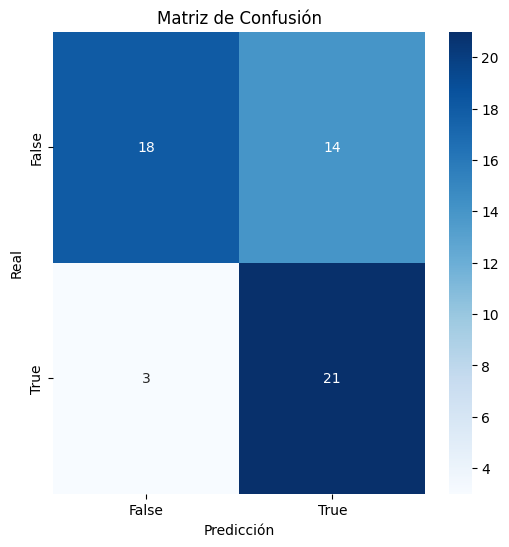

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6964285969734192     │
│         test_auc          │    0.7942708730697632     │
│        test_calib         │    0.1775156855583191     │
│          test_f1          │    0.7118644118309021     │
│      test_precision       │    0.6000000238418579     │
│        test_recall        │           0.875           │
└───────────────────────────┴───────────────────────────┘

Generando predicciones...


Predicting: |          | 0/? [00:00<?, ?it/s]


Predicciones en conjunto de prueba:
                                                 texto categoría predicción
296  Las vacunas contra la COVID-19 -13 de ellas en...      True       True
336  Si eres de los que ama tomarse una copita de v...      True       True
99   Así lo reveló el estudio en el que participaro...      True       True
516  Vacaciones de Semana Santa, buen tiempo, el ha...      True       True
227  Varios vuelos con salida de Casablanca y desti...      True       True
344  Se está haciendo viral tras recuperarse una gr...     False      False
74   MASCARILLAS.... PREFERENTEMENTE PARA CARNAVAL ...     False      False
207  El Laboratorio Biológico Chino de Wuhan es en ...     False      False
480  El Papa Francisco podría estar enfermo de Coro...     False       True
325  El expresidente del Gobierno Felipe González h...     False       True
174  Una veintena de jóvenes del entorno abertzale ...     False       True
431  El embarazo es parte de nuestra sexualidad y v

Testing: |          | 0/? [00:00<?, ?it/s]

Matriz de Confusión:
tensor([[18, 14],
        [ 3, 21]], device='cuda:0')


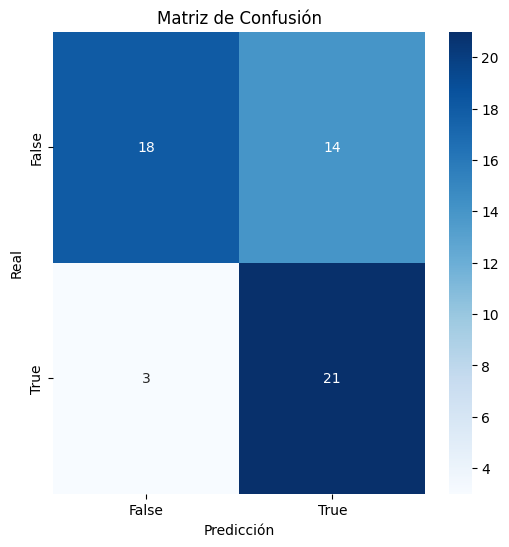

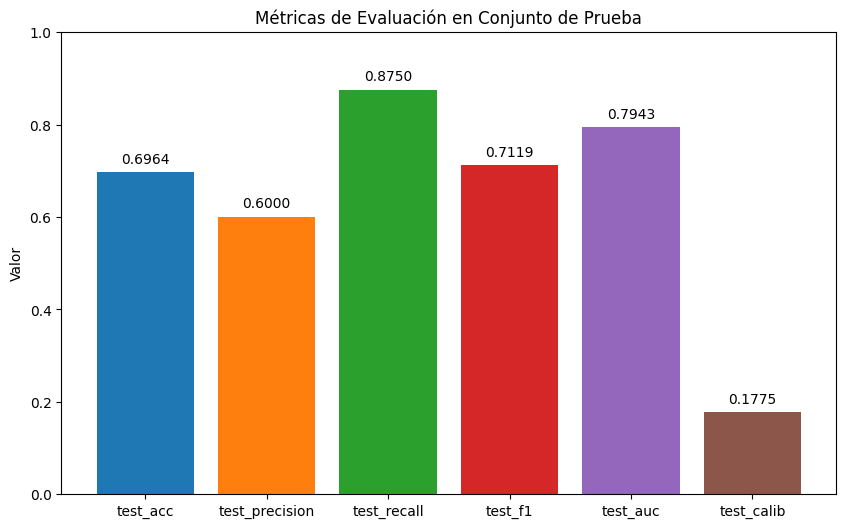


Predicción de ejemplo: 'El presidente anunció nuevas medidas económicas.' -> False (Confianza: 0.6289)


In [11]:
# Ejecución Principal
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print(f"GPU disponible: {torch.cuda.get_device_name(0)}")
        logger.info(f"GPU disponible: {torch.cuda.get_device_name(0)}")
    else:
        print("Usando CPU")
        logger.info("Usando CPU")

    dataset, class_weights = load_and_explore_dataset()
    model_name = "dccuchile/bert-base-spanish-wwm-cased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenized_dataset = preprocess_dataset(dataset, tokenizer, seq_length=256)
    train_subset, val_subset, test_subset = split_dataset(tokenized_dataset)
    test_indices = test_subset.indices

    train_dataset = FakeNewsCorpusSpanishDataset(tokenized_dataset.select(train_subset.indices), augment=True, model_name=model_name)
    val_dataset = FakeNewsCorpusSpanishDataset(tokenized_dataset.select(val_subset.indices), augment=False, model_name=model_name)
    test_dataset = FakeNewsCorpusSpanishDataset(tokenized_dataset.select(test_subset.indices), augment=False, model_name=model_name)

    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

    model = SpanishFakeNewsClassifier(
        num_classes=train_dataset.num_classes,
        train_size=len(train_subset),
        class_weights=class_weights,
        lr=3e-5,
        weight_decay=1e-2,
        dropout=0.3,
        label_smoothing=0.1,
        model_name=model_name
    )

    tb_logger = TensorBoardLogger('tb_logs', name='ClasificadorFakeNewsOptimizado')
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, mode='min'),
        ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1, filename='mejor-modelo', dirpath='checkpoints')
    ]

    trainer = pl.Trainer(
        max_epochs=30,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        logger=tb_logger,
        callbacks=callbacks,
        precision="bf16-mixed" if torch.cuda.is_available() else "32-true",
        num_sanity_val_steps=0,
        accumulate_grad_batches=1,
        log_every_n_steps=1
    )

    print("Iniciando entrenamiento...")
    logger.info("Iniciando entrenamiento")
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    print("Cargando el mejor modelo guardado...")
    best_model_path = trainer.checkpoint_callback.best_model_path
    if best_model_path:
        model = SpanishFakeNewsClassifier.load_from_checkpoint(best_model_path)
        model.to(device)
        print(f"Mejor modelo cargado desde: {best_model_path}")
        logger.info(f"Mejor modelo cargado desde: {best_model_path}")
    else:
        print("No se encontró un punto de control, usando el modelo de la última época.")
        logger.warning("No se encontró un punto de control, usando el modelo de la última época.")

    print("Evaluando en conjunto de prueba...")
    logger.info("Evaluando en conjunto de prueba")
    trainer.test(model, dataloaders=test_loader)

    print("Generando predicciones...")
    logger.info("Generando predicciones")
    model.eval()
    predictions = trainer.predict(model, dataloaders=test_loader)
    predictions = torch.cat(predictions, dim=0)
    predictions = torch.argmax(predictions, dim=-1)
    predictions = [train_dataset.id_2_class_map[pred.item()] for pred in predictions]
    df = pd.DataFrame({
        "texto": [dataset[i]['TEXT'] for i in test_indices],
        "categoría": [train_dataset.id_2_class_map[dataset[i]['CATEGORY']] for i in test_indices],
        "predicción": predictions[:len(test_indices)]
    }, index=test_indices)
    print("\nPredicciones en conjunto de prueba:")
    print(df.head(15))
    logger.info(f"Primeras 15 predicciones:\n{df.head(15)}")

    test_results = trainer.test(model, dataloaders=test_loader, verbose=False)[0]
    metrics = ['test_acc', 'test_precision', 'test_recall', 'test_f1', 'test_auc', 'test_calib']
    values = [test_results.get(m, 0) for m in metrics]
    plt.figure(figsize=(10, 6))
    plt.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
    plt.title('Métricas de Evaluación en Conjunto de Prueba')
    plt.ylabel('Valor')
    plt.ylim(0, 1)
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center')
    plt.show()

    sample_text = "El presidente anunció nuevas medidas económicas."
    prediction, confidence = predict_text(model, tokenizer, sample_text)
    print(f"\nPredicción de ejemplo: '{sample_text}' -> {prediction} (Confianza: {confidence:.4f})")
    logger.info(f"Predicción de ejemplo: '{sample_text}' -> {prediction} (Confianza: {confidence:.4f})")

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"Error en la ejecución principal: {e}")
        logger.error(f"Error en la ejecución principal: {e}")
        raise

# **7. Resultados y discusión**
---

<p style="font-size: 16px;">
    El modelo obtenido presenta un rendimiento moderado, alcanzando una exactitud del 69.6%, lo que indica que clasifica correctamente cerca de siete de cada diez ejemplos. Su capacidad de discriminación medida por el AUC es de 0.79, valor que refleja un buen desempeño para diferenciar entre clases, aunque aún lejos de un nivel excelente. En cuanto a la calibración, el valor de 0.177 revela que las probabilidades generadas no son del todo confiables y podrían requerir técnicas adicionales de ajuste como Platt scaling o isotonic regression si se busca usarlas directamente para toma de decisiones. Respecto al equilibrio entre precisión y exhaustividad, el F1-Score de 0.71 muestra un balance aceptable, aunque se observa una precisión relativamente baja (0.60), lo que significa que cuatro de cada diez predicciones positivas resultan ser falsas alarmas. Por el contrario, el recall es bastante alto (0.875), indicando que el modelo logra identificar la mayoría de los casos positivos reales. En conjunto, estos resultados sugieren que el modelo es fuerte en la detección de positivos y tiene un poder de discriminación adecuado, pero aún requiere mejoras en la precisión y en la calibración de sus probabilidades para aumentar su confiabilidad en escenarios de aplicación práctica.

# **8. Conclusiones**
---

<p style="font-size: 16px;">
    * El modelo demuestra una capacidad adecuada para diferenciar entre clases con un AUC de 0.79, lo que confirma que generaliza razonablemente bien y puede distinguir de forma consistente entre instancias positivas y negativas.<br><br>
    * La alta sensibilidad reflejada en el recall (0.875) muestra que el modelo es muy efectivo en la detección de la mayoría de los casos positivos, lo que lo hace especialmente valioso en escenarios donde es más crítico no pasar por alto positivos, como en contextos de seguridad, salud o detección temprana de fraudes.<br><br>
    * No obstante, la precisión baja (0.60) evidencia que una proporción significativa de predicciones positivas corresponde a falsos positivos, lo cual puede ser problemático en aplicaciones donde las falsas alarmas generan costos elevados o desconfianza en el sistema.<br><br>
    * El F1-Score de 0.71 refleja un balance moderado entre precisión y recall, confirmando que el modelo logra un desempeño equilibrado, aunque con margen de mejora si se busca optimizar simultáneamente ambos indicadores.<br><br>
    * El valor de calibración (0.177) indica que las probabilidades entregadas por el modelo no son completamente confiables, lo que limita su uso directo en aplicaciones donde se requiere interpretar la confianza del modelo en cada predicción, siendo recomendable aplicar técnicas de calibración adicionales.<br><br>